# Features to Images

Reference: https://bering-ivis.readthedocs.io/en/latest/scanpy_singlecell.html

## Setup

In [1]:
import sys

sys.path.append("../working")

In [2]:
import logging

logging.basicConfig(
    # filename=__file__.replace('.py', '.log'),
    level=logging.getLevelName("INFO"),
    format="%(asctime)s [%(levelname)s] [%(module)s] %(message)s",
)

log = logging.getLogger(__name__)

In [3]:
import glob
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from omegaconf import OmegaConf
from progressbar import progressbar
from src.get_score import get_score
from src.load_data import LoadData, PostprocessData, PreprocessData
from src.utils import df_stats

# from src.make_dataset import BaseDataset, get_transforms
# from src.make_model import ImageBaseModel
# from torch.utils.data import DataLoader

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_colwidth", None)

In [4]:
# Competition specific library
import math

import scanpy as sc
import scipy.stats as stats
import umap
from anndata import AnnData
from ivis import Ivis
from sklearn.preprocessing import StandardScaler

In [5]:
c = OmegaConf.load("../working/config/main.yaml")

In [6]:
input = PreprocessData(c, do_preprocess=False)

2022-10-15 12:46:36,889 [INFO] [load_data] Load pickle file. path: ../input/evaluation_ids.pickle
2022-10-15 12:46:41,969 [INFO] [load_data] Load pickle file. path: ../input/metadata.pickle
2022-10-15 12:46:42,023 [INFO] [load_data] Load pickle file. path: ../input/sample_submission.pickle
2022-10-15 12:46:42,613 [INFO] [load_data] Load pickle file. path: ../input/test_cite_inputs.pickle
2022-10-15 12:46:47,953 [INFO] [load_data] Load pickle file. path: ../input/test_cite_inputs_day_2_donor_27678.pickle
2022-10-15 12:46:50,001 [INFO] [load_data] Load pickle file. path: ../input/train_cite_inputs.pickle
2022-10-15 12:46:56,033 [INFO] [load_data] Load pickle file. path: ../input/train_cite_targets.pickle


In [7]:
dir(input)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'c',
 'evaluation_ids',
 'metadata',
 'sample_submission',
 'test_cite_inputs',
 'test_cite_inputs_day_2_donor_27678',
 'train_cite_inputs',
 'train_cite_targets']

## Preprocess

In [8]:
adata = AnnData(input.train_cite_inputs.to_numpy())
adata.obs_names = input.train_cite_inputs.index
adata.var_names = input.train_cite_inputs.columns
adata

AnnData object with n_obs × n_vars = 70988 × 22050

In [9]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

sc.pp.filter_genes(adata, min_cells=300)

In [10]:
adata.var["mt"] = adata.var_names.str.contains("_MT-")

sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False,
    inplace=True,
)

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [12]:
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var["highly_variable"]]

In [13]:
sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver="arpack")

/opt/miniconda3/envs/develop/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Visualize

In [14]:
X = adata.obsm["X_pca"]

In [15]:
ivis = Ivis(k=15, model="maaten", n_epochs_without_progress=5)
ivis.fit(X)
embeddings = ivis.transform(X)

Building KNN index


100%|██████████| 70988/70988 [00:00<00:00, 227810.76it/s]


Extracting KNN neighbours


100%|██████████| 70988/70988 [00:02<00:00, 34448.17it/s] 


Training neural network
Epoch 1/1000
555/555 [==============================] - 4s 3ms/step - loss: 0.1819
Epoch 2/1000
555/555 [==============================] - 2s 3ms/step - loss: 0.0836
Epoch 3/1000
555/555 [==============================] - 2s 3ms/step - loss: 0.0717
Epoch 4/1000
555/555 [==============================] - 2s 3ms/step - loss: 0.0669
Epoch 5/1000
555/555 [==============================] - 2s 3ms/step - loss: 0.0634
Epoch 6/1000
555/555 [==============================] - 2s 3ms/step - loss: 0.0630
Epoch 7/1000
555/555 [==============================] - 2s 3ms/step - loss: 0.0603
Epoch 8/1000
555/555 [==============================] - 2s 3ms/step - loss: 0.0610
Epoch 9/1000
555/555 [==============================] - 2s 3ms/step - loss: 0.0607
Epoch 10/1000
555/555 [==============================] - 2s 3ms/step - loss: 0.0576
Epoch 11/1000
555/555 [==============================] - 2s 3ms/step - loss: 0.0567
Epoch 12/1000
555/555 [==============================] - 2s 3

In [17]:
adata.var.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4584 entries, ENSG00000121410_A1BG to ENSG00000214941_ZSWIM7
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   n_cells                4584 non-null   int64  
 1   mt                     4584 non-null   bool   
 2   n_cells_by_counts      4584 non-null   int64  
 3   mean_counts            4584 non-null   float32
 4   pct_dropout_by_counts  4584 non-null   float64
 5   total_counts           4584 non-null   float32
 6   highly_variable        4584 non-null   bool   
 7   means                  4584 non-null   float64
 8   dispersions            4584 non-null   float64
 9   dispersions_norm       4584 non-null   float32
 10  mean                   4584 non-null   float64
 11  std                    4584 non-null   float64
dtypes: bool(2), float32(3), float64(5), int64(2)
memory usage: 478.2+ KB


In [21]:
[col for col in adata.var_names if "CST" in col]

['ENSG00000101439_CST3',
 'ENSG00000077984_CST7',
 'ENSG00000121552_CSTA',
 'ENSG00000126264_HCST']

In [22]:
fill = adata.X[:, adata.var.index=='ENSG00000101439_CST3']
fill = fill.reshape((X.shape[0], ))

In [24]:
fill.shape

(70988,)

In [18]:
adata.obs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70988 entries, 45006fe3e4c8 to c91b6b2ccd3d
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   n_genes_by_counts  70988 non-null  int64  
 1   total_counts       70988 non-null  float32
 2   total_counts_mt    70988 non-null  float32
 3   pct_counts_mt      70988 non-null  float32
dtypes: float32(3), int64(1)
memory usage: 3.9+ MB


In [19]:
embeddings.shape

(70988, 2)

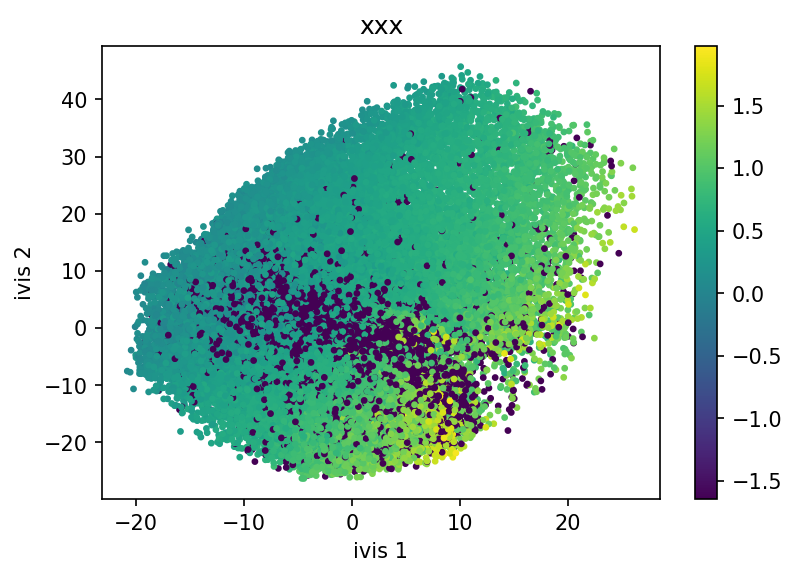

In [25]:
plt.figure(figsize=(6, 4), dpi=150)
sc = plt.scatter(x=embeddings[:, 0], y=embeddings[:, 1], c=fill, s=5)
plt.xlabel("ivis 1")
plt.ylabel("ivis 2")
plt.title("CST3")
plt.colorbar(sc)